<h1> Microsoft Stock Forecasting w/ LSTMs

Importing and refacroting to have only date and closing price

In [52]:
import pandas as pd
import datetime

df = pd.read_csv('MSFT.csv')

# We only need the date and the closing for each date
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.070576
1,1986-03-14,0.070576
2,1986-03-17,0.070576
3,1986-03-18,0.070576
4,1986-03-19,0.070576
...,...,...
9756,2024-12-02,430.980000
9757,2024-12-03,431.200000
9758,2024-12-04,437.420000
9759,2024-12-05,442.620000


In [41]:
# We need to convert the date to a Date object
def str_to_date(s):
  year, month, day = s.split('-')
  return datetime.datetime(int(year), int(month), int(day))


print(str_to_date('1989-01-01'))

1989-01-01 00:00:00


In [42]:
# Let's now convert all the string Dates to the new datetime objects
df['Date'] = df['Date'].apply(str_to_date)

# Let's also change the index to the date
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.070576
1986-03-14,0.070576
1986-03-17,0.070576
1986-03-18,0.070576
1986-03-19,0.070576
...,...
2024-12-02,430.980000
2024-12-03,431.200000
2024-12-04,437.420000


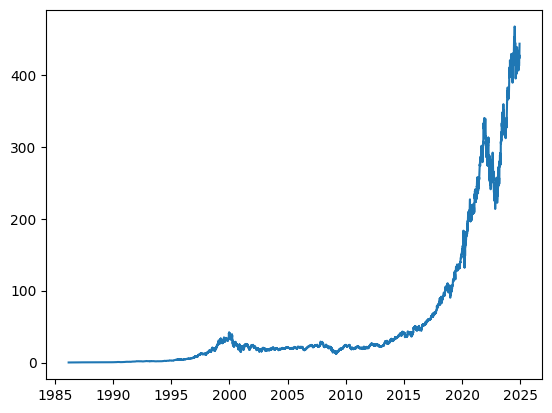

In [43]:
import matplotlib.pyplot as plt

plt.plot(df.index, df.Close)

<h2> Modifying Data <h2>

In [51]:
# Since is is a LSTM (Layered Short Term Memory RNN) we want 4 dimensions for each output in the dataset.
# In this case one will be the date, and the other will be the last 3 closing prices.
# The output will be the current date closing price. So we need a function that returns a new dataset with 4 features for each label

# This is the function used to convert
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_date(first_date_str)
  last_date  = str_to_date(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day first time: '1986-03-18'
# Start day second time around: '2022-09-12'
windowed_df = df_to_windowed_df(df,
                                '1986-03-18',
                                '2023-09-08',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-18,0.070576,0.070576,0.070576,0.070576
1,1986-03-19,0.070576,0.070576,0.070576,0.070576
2,1986-03-20,0.070576,0.070576,0.070576,0.070576
3,1986-03-21,0.070576,0.070576,0.070576,0.062951
4,1986-03-24,0.070576,0.070576,0.062951,0.062951
...,...,...,...,...,...
9439,2023-09-01,328.410000,328.790000,327.760000,328.660000
9440,2023-09-05,328.790000,327.760000,328.660000,333.550000
9441,2023-09-06,327.760000,328.660000,333.550000,332.880000
9442,2023-09-07,328.660000,333.550000,332.880000,329.910000


In [56]:
# Now lets convert the data into date, X, and Y

def refactor_into_features_and_labels(windowed_df):
  df_to_np = windowed_df.to_numpy()

  date = df_to_np[:, 0]
  middle = df_to_np [:, 1: -1]
  Y = df_to_np[:, -1]

  # reshape features to fit the model's inputs, which is len and inputs
  X = middle.reshape((len(date), middle.shape[1], 1))

  return date, X.astype(np.float32), Y.astype(np.float32)


dates, X, Y = refactor_into_features_and_labels(windowed_df)

dates.shape, X.shape, Y.shape

((9444,), (9444, 3, 1), (9444,))

<h2> Splitting Data into Training and Testing

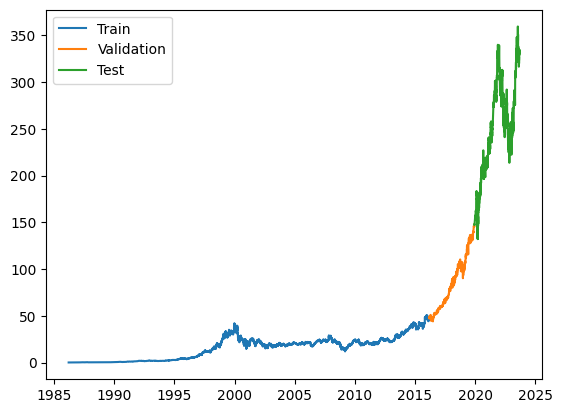

In [57]:
# Let's make is to the first 80& is training, 10% validation, and 10% testing

p80 = int(len(dates) * .8)
p90 = int(len(dates) * .9)

dates_train, X_train, Y_train = dates[: p80], X[: p80], Y[: p80]
dates_val, X_val, Y_val = dates[p80: p90], X[p80: p90], Y[p80: p90]
dates_test, X_test, Y_test = dates[p90: ], X[p90: ], Y[p90: ]

plt.plot(dates_train, Y_train)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, Y_test)
plt.legend(['Train', 'Validation', 'Test'])

<H2>Setting Up Model</h2>

In [63]:
# From tensorflow we're going to use a Sequential Layered model (NN) and the Adam (a version of SGD) to optimize

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([
    layers.Input((3,1)), # Shape of X
    layers.LSTM(65), # 65 neurons, not messing with it's activation function
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Default activation function is linear (we want linear since we want a number)
])

# Loss Function

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error']) # For our sake to see what the error rate is without squaring it

model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100)

Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 186.9894 - mean_absolute_error: 8.5227 - val_loss: 2611.6340 - val_mean_absolute_error: 41.0750
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2928 - mean_absolute_error: 0.2881 - val_loss: 2310.5918 - val_mean_absolute_error: 37.5161
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2110 - mean_absolute_error: 0.2778 - val_loss: 2212.8416 - val_mean_absolute_error: 36.3764
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.2214 - mean_absolute_error: 0.2836 - val_loss: 2175.8181 - val_mean_absolute_error: 35.9936
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1784 - mean_absolute_error: 0.2499 - val_loss: 2160.2717 - val_mean_absolute_error: 35.7151
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2050 - mean_absolute_error: 0.2714 - val_loss: 2151.2139 - val_mean_absolute_error: 35.6765
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 